# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [ ]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [ ]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    # X.shape == (5,4):  5 events (x,y,z,t)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [ ]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularization loss.

In [ ]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small; we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [ ]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

    # b1 max relative error: 6.666667e-01
    # b2 max relative error: 6.666667e-01     Something was wrong in Karpathy's code?


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.02.

In [ ]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [ ]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network

# The original settings:
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)


# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


iteration 0 / 1000: loss 2.302762
iteration 100 / 1000: loss 2.302358
iteration 200 / 1000: loss 2.297404
iteration 300 / 1000: loss 2.258897
iteration 400 / 1000: loss 2.202975
iteration 500 / 1000: loss 2.116816
iteration 600 / 1000: loss 2.049789
iteration 700 / 1000: loss 1.985711
iteration 800 / 1000: loss 2.003726
iteration 900 / 1000: loss 1.948076
Validation accuracy:  0.287


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

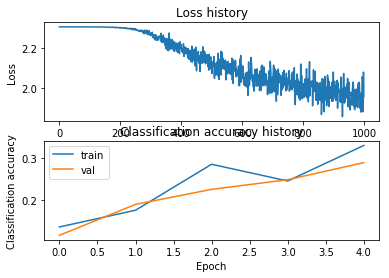

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

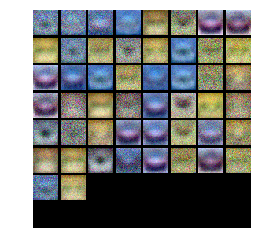

In [10]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)  # nxb: is this only for the car class?

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit Your Answer:}$

My underlying assumption is that we can find the best result by tuning one parameter at a time and then observing these actions sequentially will give us the best validation possible accuracy.  This underlying assumption may be incorrect (ie. it may not be the way to get the very best validation accuracy).

To make it clear what that means, I'll give a concrete example.  First I want to get the learning rate right.  The best validation accuracy I've gotten so far was 0.486, with hyperparameter settings learning_rate==0.00218421, batch_size==200, reg==0.25, num_iters==1000, and learning_rate_decay==0.95.  

1. First, I'm trying to get the learning rate right.  Using line plots to visualize how the validation and train accuracies vary with various hyperparameters (ie. learning rate).
2. Did the same with regularization.  Hard to tell what's going on, except for in extremely low regularization (gradients explode and are meaningless/break the NN) or for very high regularization values (squashes all gradients to nothing and the NN can't learn anything at all).  Picking in the **1e-7 - 0.25** range doesn't show me any clear differences in performance
3. Tried to learn something about how big the internal layer should be.  Again, hard to learn much about the best sizes.  *Probably* somewhere in the **50-2000** range is best, but I get a very noisy graph *within* that range.  For a deeper CNN (ie. a predictive model that *actually works*, I imagine these numbers have more meaning
4. Try to find the optimal number of iterations to train the 2-layer NN.  We don't want to overfit.

# TODO:
experiment with different values of the various hyperparameters, including
1. hidden layer size,
2. learning rate, 
3. number of training epochs, and 
4. regularization strength

# Data parameters:
Train data shape:  (49000, 3072)

Train labels shape:  (49000,)

Validation data shape:  (1000, 3072)

Validation labels shape:  (1000,)

Test data shape:  (1000, 3072)

Test labels shape:  (1000,)

In [32]:
# finding the best setting for hyperparameter "H"

import math
from collections import OrderedDict
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results     = OrderedDict()
best_net    = None # store the best model into "best_net"
best_val    = -1


input_size  = 32 * 32 * 3       # 3072 pix_vals
hidden_size = 50
num_classes = 10

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# TODO: fiddle with more hyperparams:
'''
max_lr8 = 1e-4 # too big
min_lr8 = 3.65e-3
n_lr8s=100

l_r8s=np.linspace(
    min_lr8,
    max_lr8,
    n_lr8s)  # The best learning rate was \approx ~2.18e-3
'''
# TODO:  pick a good reg value (use the best value I got from the "this is exclusively regularization tuning" run)
'''
min_reg=1e-9
max_reg=1e+9
n_regs=100
regs=np.logspace(
    math.log10(min_reg),
    math.log10(max_reg),
    num=n_regs
)
'''


"""
min_H = 20
max_H = 5000
n_H   = 20
hidden_sizes= np.round(
    np.logspace(
        math.log10(min_H),
        math.log10(max_H),
        num=n_H,
        base=10.
    )
).astype('int64')
"""
#==============================================================================
regs=[2.5e-5]  #, 2.5e-5]  # 0.25]  #0.25]#, 0.5]
l_r8s = [2e-3] # near the best, according to previous trials
hidden_sizes=[100]   #[50] # <= this (50) is the original

#batch_size
bs=100#1# 200
#==============================================================================
# num_iters      / num_epochs
nis=[1000]
min_ni = 200
max_ni = 10000
n_ni   = 50
nis= np.round(
    np.logspace(
        math.log10(min_ni),
        math.log10(max_ni),
        num=n_ni,
        base=10.
    )
).astype('int64')
# learning rate decay:
lrd=0.95

# best learning rate (by validation accuracy)
# (with all other params as default))  :  0.0021842105263157902

#==============================================================================
for l_r8 in l_r8s:
    for reg in regs:
        for hidden_size in hidden_sizes:
            for ni in nis:
                net = TwoLayerNet(input_size, hidden_size, num_classes)

                stats = net.train(X_train, y_train, X_val, y_val,
                            num_iters=ni,
                            batch_size=bs,
                            learning_rate=l_r8,
                            learning_rate_decay=lrd,
                            reg=reg,
                            verbose=False) #True)
                #print("final loss: {0}".format(stats['loss_history'][0]))
                # final loss is only an issue if the NN is *REALLY* screwing up (like it was when batch_size=1)
                #


                #loss_hist     = stats['loss_history']
                train_acc_hist= stats['train_acc_history']
                val_acc_hist  = stats['val_acc_history']
                val           = val_acc_hist[-1]
                train         = train_acc_hist[-1]

                print("The NN currently being trained's parameters: {0}".format(net.hyperparams))
                print("accuracies: \n val = {0} \n train ={1}\n".format(val, train))
                # Save best:
                if val > best_val:
                    best_net = net
                    best_val = val

                # Save all:
                results[(l_r8, reg, hidden_size, ni)] = (train, val)

#print("After all the looping, \nresults = "+str(results))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


hidden layer's size: 100
accuracies: 
 val = 0.185 
 train =0.33

hidden layer's size: 100
accuracies: 
 val = 0.136 
 train =0.22

hidden layer's size: 100
accuracies: 
 val = 0.156 
 train =0.42

hidden layer's size: 100
accuracies: 
 val = 0.146 
 train =0.29

hidden layer's size: 100
accuracies: 
 val = 0.147 
 train =0.22

hidden layer's size: 100
accuracies: 
 val = 0.154 
 train =0.34

hidden layer's size: 100
accuracies: 
 val = 0.134 
 train =0.29

hidden layer's size: 100
accuracies: 
 val = 0.146 
 train =0.3

hidden layer's size: 100
accuracies: 
 val = 0.12 
 train =0.29

hidden layer's size: 100
accuracies: 
 val = 0.154 
 train =0.35

hidden layer's size: 100
accuracies: 
 val = 0.164 
 train =0.32

hidden layer's size: 100
accuracies: 
 val = 0.158 
 train =0.33

hidden layer's size: 100
accuracies: 
 val = 0.378 
 train =0.48

hidden layer's size: 100
accuracies: 
 val = 0.387 
 train =0.66

hidden layer's size: 100
accuracies: 
 val = 0.43 
 train =0.62

hidden layer'

In [33]:
#hidden_sizes
nis

array([  200,   217,   235,   254,   275,   298,   323,   350,   379,
         410,   444,   481,   521,   565,   612,   662,   717,   777,
         842,   912,   987,  1069,  1158,  1255,  1359,  1472,  1594,
        1727,  1870,  2026,  2194,  2376,  2574,  2788,  3019,  3270,
        3542,  3836,  4155,  4501,  4875,  5280,  5719,  6194,  6709,
        7266,  7870,  8524,  9233, 10000])

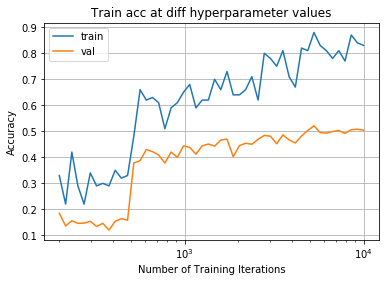

In [34]:
# Plot the loss at various hyperparam values:
# 1. lr
# 2. reg
# 3. H (hidden_layer size)
# 4. # train epochs

#results[(l_r8, reg)] = (train, val)
params_x = []
train_y  = []
val_y    = []

LR=0
REG=1
HIDDEN=2
ITERS=3
for k,v in results.items():
    #params_x.append(k[LR]) #lr
    #params_x.append(k[REG]) # reg
    #params_x.append(k[HIDDEN]) # 
    params_x.append(k[ITERS])
    train_y.append(v[0])
    val_y.append(v[1])


# lr :


#plt.subplot(2, 1, 1)
#plt.plot(stats['loss_history'])
plt.title('Train acc at diff hyperparameter values')
plt.xlabel('Number of Training Iterations')
#plt.xlabel('Hidden Layer\'s size')
#plt.xlabel('Learning Rate')
#plt.xlabel('Regularization strength')
plt.ylabel('Accuracy')
plt.plot(params_x, train_y, label='train')
plt.plot(params_x, val_y,   label='val')
plt.xscale('log')
plt.grid(True)

#plt.subplot(2, 1, 2)
#plt.plot(stats['train_acc_history'], label='train')
#plt.plot(stats['val_acc_history'], label='val')
#plt.title('Classification accuracy history')
#plt.xlabel('Epoch')
#plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [35]:
print("params_x: ", params_x)
print("val_y:    ", val_y)
idx=np.nonzero(params_x==49)
print("where is H==49 ?  ", idx)
print("what is acc at H==49 ?  ", val_y[idx])

params_x:  [200, 217, 235, 254, 275, 298, 323, 350, 379, 410, 444, 481, 521, 565, 612, 662, 717, 777, 842, 912, 987, 1069, 1158, 1255, 1359, 1472, 1594, 1727, 1870, 2026, 2194, 2376, 2574, 2788, 3019, 3270, 3542, 3836, 4155, 4501, 4875, 5280, 5719, 6194, 6709, 7266, 7870, 8524, 9233, 10000]
val_y:     [0.185, 0.136, 0.156, 0.146, 0.147, 0.154, 0.134, 0.146, 0.12, 0.154, 0.164, 0.158, 0.378, 0.387, 0.43, 0.422, 0.409, 0.378, 0.42, 0.4, 0.444, 0.438, 0.412, 0.444, 0.451, 0.443, 0.466, 0.47, 0.402, 0.445, 0.454, 0.45, 0.469, 0.484, 0.481, 0.452, 0.486, 0.467, 0.455, 0.482, 0.503, 0.521, 0.495, 0.493, 0.499, 0.503, 0.492, 0.506, 0.508, 0.504]
where is H==49 ?   (array([], dtype=int64),)


TypeError: list indices must be integers or slices, not tuple

In [ ]:
#params_x # long
trains=OrderedDict()
vals=OrderedDict()
for reg in params_x:
    vals[reg] = results[l_r8, reg]
    trains[reg] = results[l_r8, reg]

best_val=-1
best=None
VAL=1
for reg,accs in vals.items():
    if accs[VAL] > best_val:
        best_reg=reg
        best_val=accs[VAL]

In [ ]:
best_

In [36]:
best_val

0.521

In [37]:
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy:  0.495


In [39]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.494


In [40]:
best_net.hyperparams

OrderedDict([('learning_rate', 0.002),
             ('reg', 2.5e-05),
             ('H', 100),
             ('num_iters', 5280),
             ('batch_size', 100)])

In [41]:
#import cPickle as pkl
import pickle as pkl
pkl_fname = "best_2_layer_NN__test_acc_is_{0}.pkl".format(test_acc)
# save neural net object to file
with open(pkl_fname, "wb") as out_pkl_file:
        pkl.dump(best_net, out_pkl_file)

# The latest version of this best 0.48 test accuracy!  I think it was the weight initialization.

In [42]:
import pickle as pkl
import datetime
# save "results" dict to file
timestamp=datetime.datetime.now().strftime('%Y_%m_%d____%H:%M_%p__') # p is for P.M. vs. A.M.
with open("results_dict___"+timestamp+".pkl", "wb") as out_pkl_file:
  pkl.dump(results, out_pkl_file)

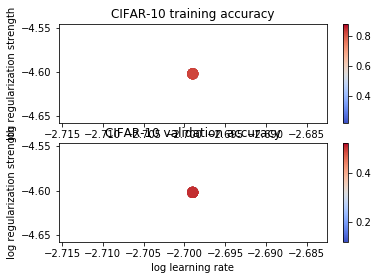

In [43]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

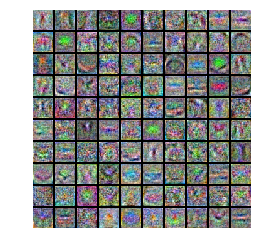

In [30]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [39]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.494


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$
I think it's 2 and 3.  (July 4, 2019).  I've yet to do justice and properly take notes on the cs231n lectures (https://www.youtube.com/watch?v=d14TUNcbn1k&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=4) by July 4, 2019, though.

I think the answer is 4.  But it depends on what each suggestion *means* (I will qualify the "yes" answers I give)  (July 4, 2019; 18:26:13 EDT 2019).  Each of the answers is true at a happy medium

$\color{blue}{\textit Your Explanation:}$
(July 4, 2019; *after* 18:26:13 EDT):
1. is wrong *unless* the bigger training set is less biased than the original training set.  (ie. all the cats in your training set are directly facing the camera, but in the larger set you have images of them from the side, behind, etc.)
2.  More hidden units.  won't necessarily improve the model.  If the model gets *deeper*, a Neural Network that matches the problemmay properly learn more sophisticated features of the dataset (for instance, in a *deep* CNN for Computer Vision, some of the layers will learn ears, eyes, stripes, earlier layers will learn edges, etc.).  But making our toy 2-layer NN *wider* didn't improve performance in any obvious way.
3.  A good regularization strength is a happy medium.  In our problem, values of "reg" in the **1e-7 - 0.25** range all seemed to work about equally well.  Extremely low regularization is bad; the gradients and weights explode to infinity/NaN inside the NN and we lose all utility.  Very high regularization values are also bad; this squashes all weights and gradients to 0 and the "neurons" in NN can't learn anything at all.


(July 4, 2019; before 18:26:13 EDT):
1 would be true if the larger dataset fixed bias problems in the smaller dataset (ie. all the cats in your training set are directly facing the camera, but in the larger set you have images of them from the side, behind, etc.

I'm guessing 2 might help improve test accuracy; the model has more capacity to learn different features from the images.

Even 3. doesn't always work, though.  Increase the regularization too much, and the weights will just remain small the whole time; the NN can't learn.  Reg seems less important than the learning rate.


In [56]:
#################################################################################
# How can we decrease the train-val gap?
#    (in other words, how can we increase model performance?)
#################################################################################
# 1. larger training set
# 2. more hidden units
# 3. regularization strength
#################################################################################

import math
from collections import OrderedDict
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results     = OrderedDict()
best_net    = None # store the best model into "best_net"
#best_val_minus_train=-float("inf")
best_y_to_plot=-float('inf')
best_val    = -1


input_size  = 32 * 32 * 3       # 3072 pix_vals
hidden_size = 50
num_classes = 10

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# TODO: fiddle with more hyperparams:
'''
max_lr8 = 1e-4 # too big
min_lr8 = 3.65e-3
n_lr8s=100

l_r8s=np.linspace(
    min_lr8,
    max_lr8,
    n_lr8s)  # The best learning rate was \approx ~2.18e-3
'''
# TODO:  pick a good reg value (use the best value I got from the "this is exclusively regularization tuning" run)

min_reg=1e-7
max_reg=1e+0
n_regs=7
regs=np.logspace(
    math.log10(min_reg),
    math.log10(max_reg),
    num=n_regs
)




min_H = 50
max_H = 500
n_H   = 10
hidden_sizes= np.round(
    np.logspace(
        math.log10(min_H),
        math.log10(max_H),
        num=n_H,
        base=10.
    )
).astype('int64')

#==============================================================================
#regs=[2.5e-5]  #, 2.5e-5]  # 0.25]  #0.25]#, 0.5]
l_r8s = [2e-3] # near the best, according to previous trials
#hidden_sizes=[100]   #[50] # <= this (50) is the original

#batch_size
bs=100#1# 200
#==============================================================================
# num_iters      / num_epochs
nis=[5280]
'''
min_ni = 200
max_ni = 10000
n_ni   = 4
nis= np.round(
    np.logspace(
        math.log10(min_ni),
        math.log10(max_ni),
        num=n_ni,
        base=10.
    )
).astype('int64')
'''

# learning rate decay:
lrd=0.95

# best learning rate (by validation accuracy)
# (with all other params as default))  :  0.0021842105263157902

#==============================================================================
for l_r8 in l_r8s:
    for reg in regs:
        for hidden_size in hidden_sizes:
            for ni in nis:
                net = TwoLayerNet(input_size, hidden_size, num_classes)

                stats = net.train(X_train, y_train, X_val, y_val,
                            num_iters=ni,
                            batch_size=bs,
                            learning_rate=l_r8,
                            learning_rate_decay=lrd,
                            reg=reg,
                            verbose=False) #True)

                #loss_hist     = stats['loss_history']
                train_acc_hist= stats['train_acc_history']
                val_acc_hist  = stats['val_acc_history']
                val           = val_acc_hist[-1]
                train         = train_acc_hist[-1]
                y_to_plot     = val-train

                print("The NN currently being trained's parameters: {0}".format(net.hyperparams))
                print("accuracies: \n val = {0} \n train ={1}\n".format(val, train))
                # Save best:
                if y_to_plot > best_y_to_plot:
                    best_net = net
                    best_y_to_plot = y_to_plot

                # Save all:
                results[(l_r8, reg, hidden_size, ni)] = y_to_plot
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 1e-07), ('H', 50), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.489 
 train =0.77

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 1e-07), ('H', 65), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.489 
 train =0.78

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 1e-07), ('H', 83), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.469 
 train =0.71

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 1e-07), ('H', 108), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.446 
 train =0.7

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 1e-07), ('H', 139), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.438 
 train =0.78

The NN currently being t

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 0.004641588833612782), ('H', 50), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.474 
 train =0.77

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 0.004641588833612782), ('H', 65), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.48 
 train =0.76

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 0.004641588833612782), ('H', 83), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.478 
 train =0.73

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 0.004641588833612782), ('H', 108), ('num_iters', 5280), ('batch_size', 100)])
accuracies: 
 val = 0.469 
 train =0.75

The NN currently being trained's parameters: OrderedDict([('learning_rate', 0.002), ('reg', 0.004641588833612782), ('H', 139), ('num_iters', 5280), ('batch_size

In [65]:
# best_y_to_plot:
OrderedDict([('learning_rate', 0.002),
             ('reg', 1.0),
             ('H', 300),
             ('num_iters', 5280),
             ('batch_size', 100)])

OrderedDict([('learning_rate', 0.002),
             ('reg', 1.0),
             ('H', 300),
             ('num_iters', 5280),
             ('batch_size', 100)])

In [57]:
class InvalidArgumentError(RuntimeError):
    def __init__(self, message):
        super().__init__()
        self.message = message
    def __str__(self):
        return self.message

In [58]:
def plot(results_dict, which='reg'):
    results=results_dict

    LR=0
    REG=1
    HIDDEN=2
    ITERS=3
    # switch statement (would be "case"s in Java)
    if which=='reg':
        WHICH=REG
    elif which =='hidden':
        WHICH=HIDDEN
    elif which == 'lr':
        WHICH=LR
    elif which == 'epochs':
        WHICH=ITERS
    else:
        raise InvalidArgumentError("Please pass a valid 'which' parameter argument.  Currently supported as of July 4, 2019 are 'reg', 'hidden', 'lr', and 'epochs'")
        
    xs = []
    ys  = []
    for k,v in results.items():
        #params_x.append(k[LR]) #lr
        #params_x.append(k[REG]) # reg
        #params_x.append(k[HIDDEN]) # 
        xs.append(k[WHICH])  # the keys    are tuples with a buncha possible values
        ys.append(v)

    plt.title('Performance at diff hyperparameter values')
    plt.xlabel(which)
    plt.ylabel('Accuracy')
    plt.plot(xs, train_y, label='train')
    plt.xscale('log')
    plt.grid(True)

    #plt.subplot(2, 1, 2)
    #plt.plot(stats['train_acc_history'], label='train')
    #plt.plot(stats['val_acc_history'], label='val')
    #plt.title('Classification accuracy history')
    #plt.xlabel('Epoch')
    #plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()

In [60]:
for k,v in results.items():
    

NameError: name 'xs' is not defined

In [62]:
print("best_y_to_plot: ", best_y_to_plot)
results

best_y_to_plot:  -0.12299999999999994


OrderedDict([((0.002, 1e-07, 50, 5280), -0.281),
             ((0.002, 1e-07, 65, 5280), -0.29100000000000004),
             ((0.002, 1e-07, 83, 5280), -0.241),
             ((0.002, 1e-07, 108, 5280), -0.25399999999999995),
             ((0.002, 1e-07, 139, 5280), -0.342),
             ((0.002, 1e-07, 180, 5280), -0.44800000000000006),
             ((0.002, 1e-07, 232, 5280), -0.31799999999999995),
             ((0.002, 1e-07, 300, 5280), -0.39199999999999996),
             ((0.002, 1e-07, 387, 5280), -0.377),
             ((0.002, 1e-07, 500, 5280), -0.353),
             ((0.002, 1.4677992676220705e-06, 50, 5280), -0.248),
             ((0.002, 1.4677992676220705e-06, 65, 5280), -0.21899999999999997),
             ((0.002, 1.4677992676220705e-06, 83, 5280), -0.347),
             ((0.002, 1.4677992676220705e-06, 108, 5280),
              -0.31700000000000006),
             ((0.002, 1.4677992676220705e-06, 139, 5280), -0.309),
             ((0.002, 1.4677992676220705e-06, 180, 5280), -

ValueError: x and y must have same first dimension, but have shapes (70,) and (50,)

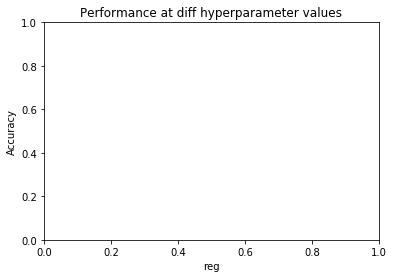

In [59]:
plot(results, which='reg')

In [ ]:
plot(results, which='hidden')

In [ ]:
# have to plot properly (do a box plot w.r.t. each different training run since I did a whole bunch of runs at each reg && "hidden" parameter setting)

In [63]:
best_y_to_plot

-0.12299999999999994

In [64]:
best_net.hyperparams

OrderedDict([('learning_rate', 0.002),
             ('reg', 1.0),
             ('H', 300),
             ('num_iters', 5280),
             ('batch_size', 100)])

In [ ]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

In [66]:
#import cPickle as pkl
import pickle as pkl
timestamp=datetime.datetime.now().strftime('%Y_%m_%d____%H:%M_%p__') # p is for P.M. vs. A.M.
pkl_fname = "best_2_layer_NN__best_y_to_plot_is_{0}____timestamp_{1}.pkl".format(best_y_to_plot, timestamp)
# save neural net object to file
with open(pkl_fname, "wb") as out_pkl_file:
        pkl.dump(best_net, out_pkl_file)

# The latest version of this best 0.48 test accuracy!  I think it was the weight initialization.
import pickle as pkl
import datetime
# save "results" dict to file
timestamp=datetime.datetime.now().strftime('%Y_%m_%d____%H:%M_%p__') # p is for P.M. vs. A.M.
with open("results_dict___best_y_to_plot_is_{0}".format(best_y_to_plot)+timestamp+".pkl", "wb") as out_pkl_file:
  pkl.dump(results, out_pkl_file)

#  Below cells are only used for debugging.

#  Below cells are only used for debugging.

#  Below cells are only used for debugging.

#  Below cells are only used for debugging.

#  Below cells are only used for debugging.

#  Below cells are only used for debugging.

#  Below cells are only used for debugging.

# reload the old 2-layer NN file  (turn cell into code)
import pickle as pkl
with open("best_2_layer_NN___test_acc_is_0.481.pkl", "rb") as load_pkl_file:
  nn=pkl.load(load_pkl_file)


In [ ]:
import pickle as pkl
fname="best_2_layer_NN___test_acc_is_0.481.pkl" #0.486.pkl"
with open(fname, "rb") as load_pkl_file:
  nn=pkl.load(load_pkl_file)


In [ ]:
nn.hyperparams

In [ ]:
val_acc = (nn.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

In [ ]:
test_acc = (nn.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

In [ ]:
import pickle as pkl
with open("best_2_layer_NN__test_acc_is_0.486.pkl", "rb") as load_pkl_file:
  nn=pkl.load(load_pkl_file)


In [ ]:
#best_net.hyperparams
nn.hyperparams

# Training on top

##### x_scatter is log10(lr for lr8 in results)             learning rate
##### y_scatter is log10(regs for reg in results)   in results

The question is just "how do we translate these axes into real values?"

It seems that reg==0.25 is better than reg==0.5 ?

# Validation on bottom

In [ ]:
1

print("learning rates: ", params_x)
print("train_y: ", train_y)
print("val_y: ", val_y)

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

In [ ]:
# Plot by regularization strength:

# Plot by regularization strength:

# Plot by regularization strength:

# Plot by regularization strength:

# Plot by regularization strength:

# Plot by regularization strength:









# Plot the loss at various hyperparam values:
# 1. lr
# 2. reg
# 3. H (hidden_layer size)
# 4. # train epochs

#results[(l_r8, reg)] = (train, val)
params_x = []
train_y  = []
val_y    = []

for k,v in results.items():
    #params_x.append(k[0]) #lr
    params_x.append(k[1]) # reg
    train_y.append(v[0])
    val_y.append(v[1])


# lr :


#plt.subplot(2, 1, 1)
#plt.plot(stats['loss_history'])
plt.title('Train acc at diff hyperparameter values')
plt.xlabel('Regularization strength')
plt.ylabel('Accuracy')
plt.plot(params_x, train_y, label='train')
plt.plot(params_x, val_y,   label='val')
plt.xscale('log')
plt.grid(True)

#plt.subplot(2, 1, 2)
#plt.plot(stats['train_acc_history'], label='train')
#plt.plot(stats['val_acc_history'], label='val')
#plt.title('Classification accuracy history')
#plt.xlabel('Epoch')
#plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot by learning rate:

# Plot by learning rate:

# Plot by learning rate:

# Plot by learning rate:

# Plot by learning rate:

# Plot by learning rate:









# Plot the loss at various hyperparam values:
# 1. lr
# 2. reg
# 3. H (hidden_layer size)
# 4. # train epochs

#results[(l_r8, reg)] = (train, val)
params_x = []
train_y  = []
val_y    = []

for k,v in results.items():
    params_x.append(k[0]) #lr
    #params_x.append(k[1]) # reg
    train_y.append(v[0])
    val_y.append(v[1])


# lr :


#plt.subplot(2, 1, 1)
#plt.plot(stats['loss_history'])
plt.title('Train acc at diff hyperparameter values.  Log scale.')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.plot(params_x, train_y, label='train')
plt.plot(params_x, val_y,   label='val')
plt.xscale('log')
plt.grid(True)

plt.legend()
plt.show()

In [ ]:
# neural network hidden layer size:

import math
from collections import OrderedDict
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results     = OrderedDict()
best_net    = None # store the best model into "best_net"
best_val    = -1

input_size  = 32 * 32 * 3       # 3072 pix_vals
hidden_size = 50
num_classes = 10

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# TODO: fiddle with more hyperparams:
l_r8s = [2e-3] # near the best, according to previous trials
'''
max_lr8 = 1e-4 # too big
min_lr8 = 3.65e-3
n_lr8s=100

l_r8s=np.linspace(
    min_lr8,
    max_lr8,
    n_lr8s)  # The best learning rate was \approx ~2.18e-3
'''
min_reg=1e-13
max_reg=1e-3
n_regs=20
regs=np.logspace(
    math.log10(min_reg),
    math.log10(max_reg),
    num=n_regs
)
#regs=[0.25]#, 0.5]

# best learning rate (by validation accuracy)
# (with all other params as default))  :  0.0021842105263157902

for l_r8 in l_r8s:
    for reg in regs:
        net = TwoLayerNet(input_size, hidden_size, num_classes)

        stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=1000, batch_size=200,
                    learning_rate=l_r8, learning_rate_decay=0.95,
                    reg=reg, verbose=False)
        loss_hist     = stats['loss_history']
        train_acc_hist= stats['train_acc_history']
        val_acc_hist  = stats['val_acc_history']
        val           = val_acc_hist[-1]
        train         = train_acc_hist[-1]

        # Save best:
        if val > best_val:
            best_net = net
            best_val = val

        # Save all:
        results[(l_r8, reg)] = (train, val)

#print("After all the looping, \nresults = "+str(results))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
